In [17]:
from Bio import SeqIO
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from Bio import pairwise2
import pandas as pd
from collections import defaultdict
import multiprocessing
import itertools
# Step 1: Read FASTA File and Convert Sequences to Feature Vectors

# Function to convert a sequence to a k-mer frequency vector
def seq_to_kmer_freq(seq, k=3):
    kmer_list = [seq[i:i+k] for i in range(len(seq) - k + 1)]
    kmer_freq = Counter(kmer_list)
    return np.array([kmer_freq.get(kmer, 0) for kmer in all_kmers])

# Read sequences
fasta_file = "../data/sequence_libraries/pseudoknot90_puzzle_11387276.tsv.RNA_sequences.fa"
sequences = {}
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences[record.id] = str(record.seq)

# Generate all possible k-mers of length 3
nucleotides = ['A', 'C', 'G', 'U']
all_kmers = [''.join(p) for p in itertools.product(nucleotides, repeat=3)]

# Convert sequences to k-mer frequency vectors
X = np.array([seq_to_kmer_freq(seq) for seq in sequences.values()])

# Step 2: Cluster Sequences Using k-means
kmeans = KMeans(n_clusters=10)  # Choose an appropriate number of clusters
labels = kmeans.fit_predict(X)

# Group sequences by their cluster label
clustered_sequences = defaultdict(list)
for label, seq_id in zip(labels, sequences.keys()):
    clustered_sequences[label].append(seq_id)

# Step 3: Calculate Pairwise Sequence Similarities Within Each Cluster

def calc_similarities(cluster):
    seq_ids = clustered_sequences[cluster]
    similarities = {}
    for i, seq_id1 in enumerate(seq_ids):
        sim_scores = []
        for j, seq_id2 in enumerate(seq_ids):
            if i != j:
                alignment = pairwise2.align.globalxx(sequences[seq_id1], sequences[seq_id2])
                sim_scores.append((seq_id2, alignment[0].score))
        similarities[seq_id1] = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:5]
    return similarities

# Step 4: Use Multiprocessing to Speed Up the Calculations with 8 CPUs
with multiprocessing.Pool(processes=8) as pool:
    all_similarities = pool.map(calc_similarities, clustered_sequences.keys())


# Convert the result to a Pandas DataFrame and save as CSV
df_rows = [(seq_id, *sim) for cluster_sim in all_similarities for seq_id, top5 in cluster_sim.items() for sim in top5]
df = pd.DataFrame(df_rows, columns=["seq_id", "similar_seq_id", "score"])
#df.to_csv("top5_similar_sequences.csv", index=False)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [70]:
df.query("score>90")

,seq_id,similar_seq_id,score


,seq_id,similar_seq_id,score
0,11459077,11458911,150.0
1,11459077,11458954,149.0
2,11459077,11458901,143.0
3,11459077,11458947,140.0
4,11459077,11458872,140.0
...,...,...,...
10860,11394874,11394878,150.0
10861,11394874,11398323,138.0
10862,11394874,11412414,127.0
10863,11394874,11451329,126.0


In [20]:
df.to_csv("top5_similar_sequences.csv", index=False)

In [21]:
df.groupby('seq_id').agg(list)

,similar_seq_id,score
seq_id,,
11394782,"[11394788, 11398344, 11435376, 11414761, 11435...","[151.0, 145.0, 124.0, 121.0, 120.0]"
11394788,"[11394782, 11398344, 11435376, 11435779, 11431...","[151.0, 144.0, 124.0, 120.0, 120.0]"
11394874,"[11394878, 11398323, 11412414, 11451329, 11451...","[150.0, 138.0, 127.0, 126.0, 125.0]"
11394878,"[11394874, 11398323, 11451329, 11412414, 11451...","[150.0, 139.0, 127.0, 127.0, 126.0]"
11394880,"[11394882, 11429152, 11453586, 11453555, 11453...","[137.0, 128.0, 125.0, 125.0, 125.0]"
...,...,...
11459047,"[11458338, 11459034, 11458332, 11458346, 11458...","[145.0, 143.0, 141.0, 138.0, 135.0]"
11459053,"[11454145, 11452890, 11451515, 11449874, 11417...","[124.0, 124.0, 124.0, 124.0, 124.0]"
11459066,"[11459036, 11459070, 11456271, 11458756, 11428...","[151.0, 148.0, 146.0, 144.0, 128.0]"


In [37]:
import pandas as pd
import polars as pl

In [71]:
df = pd.read_csv("top5_similar_sequences.csv")

In [72]:
df['score'] = df['score']/157

In [73]:
df.sort_values(by='score',ascending=False, inplace=True)

In [78]:
df.query("score>0.95")['seq_id'].unique().shape

(599,)

In [81]:
df['seq_id'].unique().shape

(2173,)

In [64]:
from Bio import SeqIO
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from Bio import pairwise2
import pandas as pd
from collections import defaultdict
import multiprocessing


In [65]:
fasta_file = "../data/sequence_libraries/pseudoknot90_puzzle_11387276.tsv.RNA_sequences.fa"
sequences = {}
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences[record.id] = str(record.seq)

In [66]:
seq1= sequences['11445334']
seq2 = sequences['11445332']

In [69]:
df.head(40)

,seq_id,similar_seq_id,score
5960,11445334,11445332,0.974522
8830,11458927,11458939,0.974522
2030,11417096,11417094,0.974522
9275,11452798,11409502,0.974522
10645,11421427,11422441,0.974522
5965,11445332,11445334,0.974522
8625,11405993,11442135,0.974522
6445,11424703,11457551,0.974522
8785,11395650,11395057,0.974522
8820,11458939,11458927,0.974522


In [53]:
import matplotlib.pyplot as plt

def plot_nucleotide_match(seq1, seq2):
    min_length = min(len(seq1), len(seq2))

    colors = ['g' if seq1[i] == seq2[i] else 'r' for i in range(min_length)]

    plt.figure(figsize=(10, 1))  # Width x Height
    plt.ylim(0.5, 1.5)  # Adjust the y-axis limits

    plt.scatter(range(min_length), [1]*min_length, c=colors)
    plt.yticks([])  # Hide the y-axis
    plt.xlabel('Nucleotide Position')
    plt.title('Nucleotide Match between seq1 and seq2')



    plt.show()


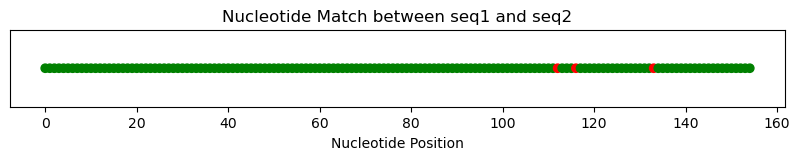

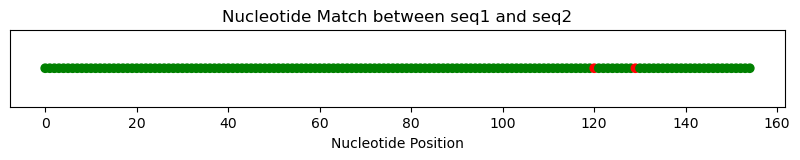

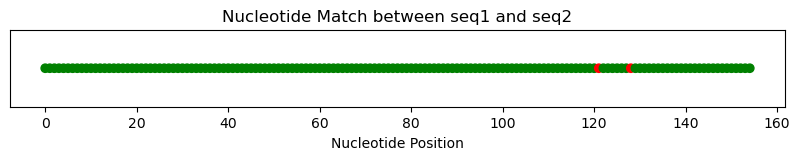

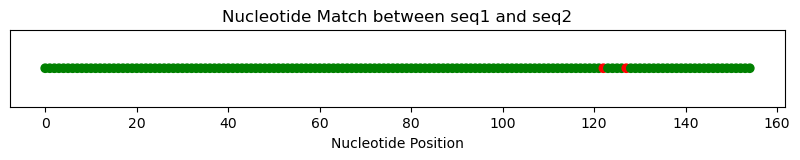

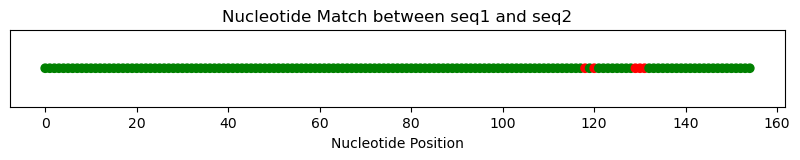

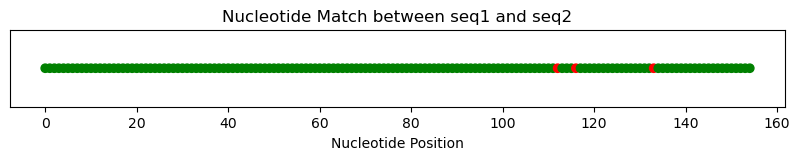

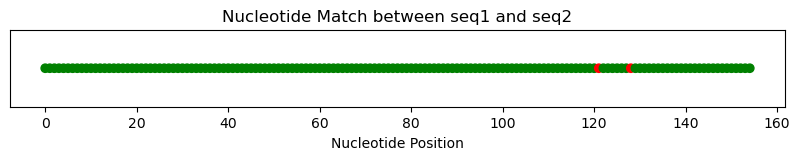

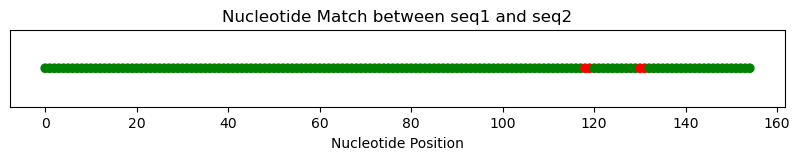

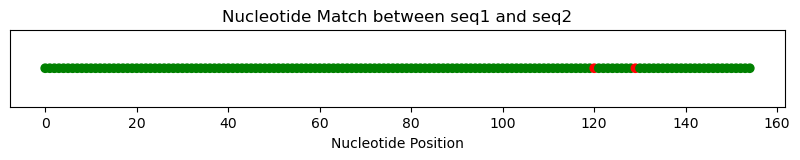

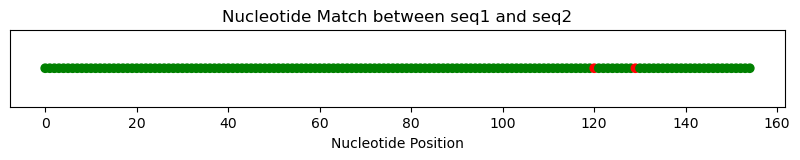

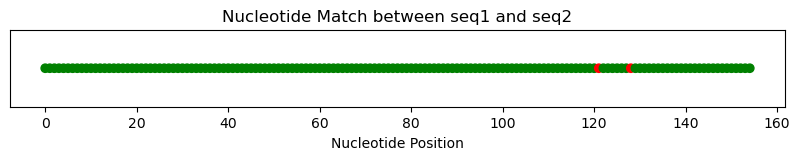

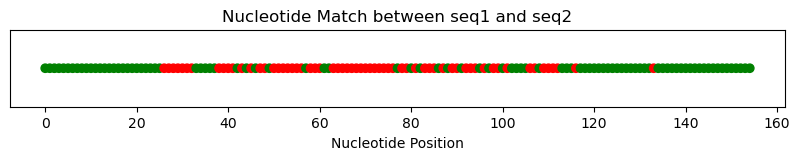

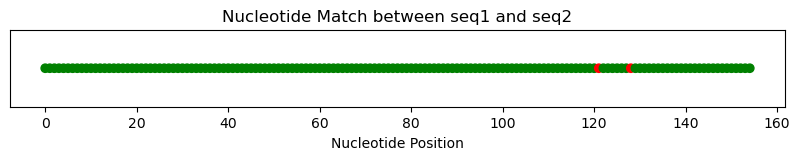

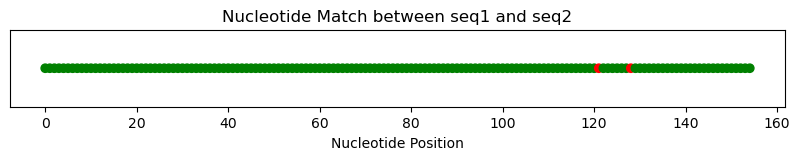

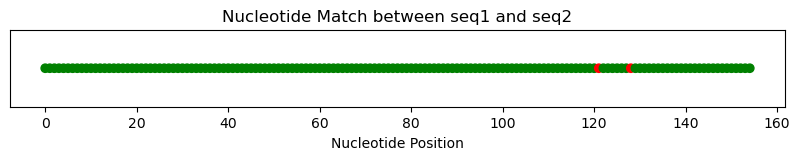

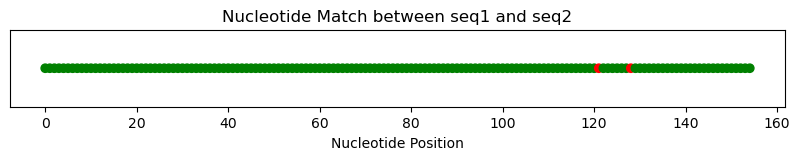

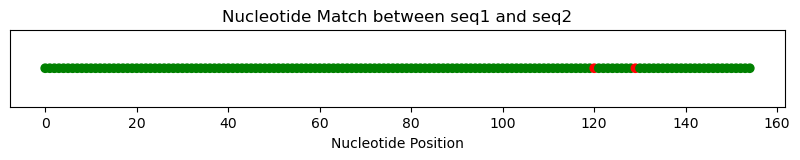

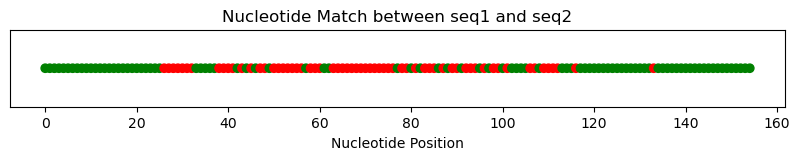

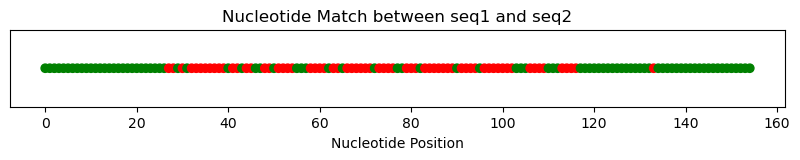

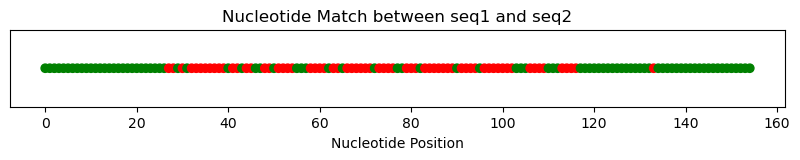

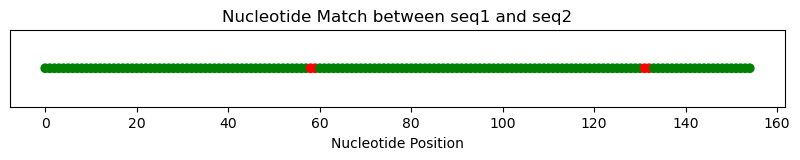

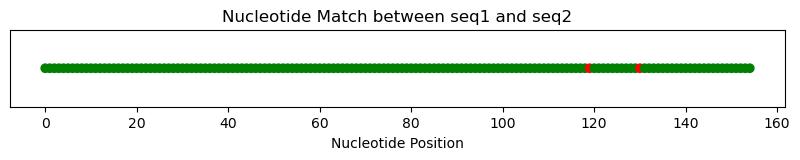

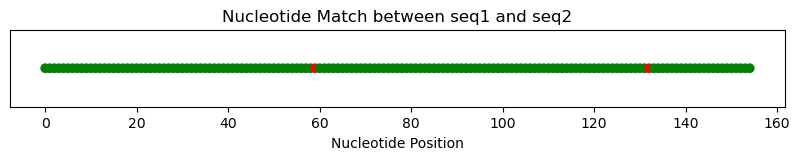

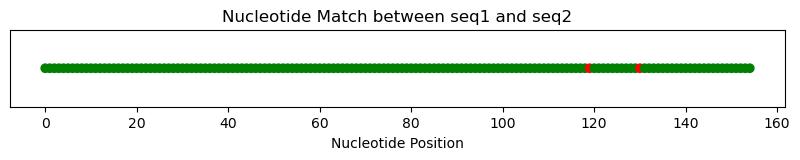

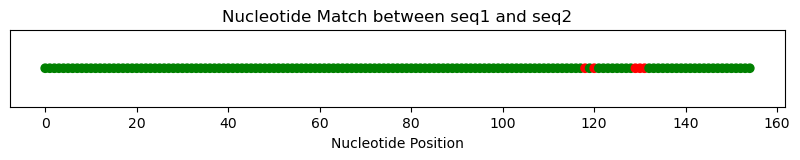

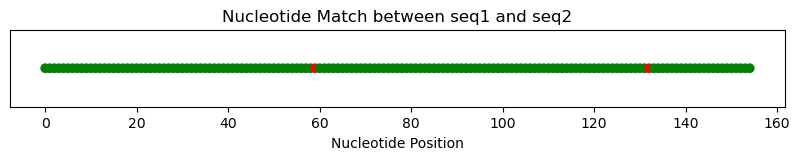

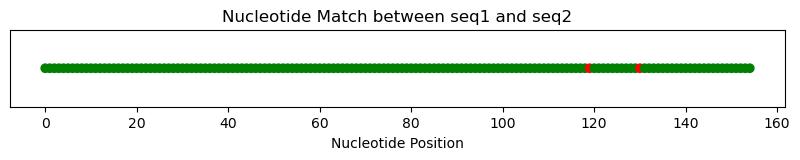

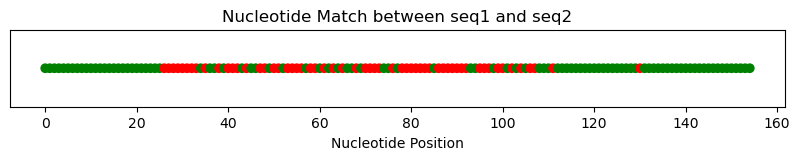

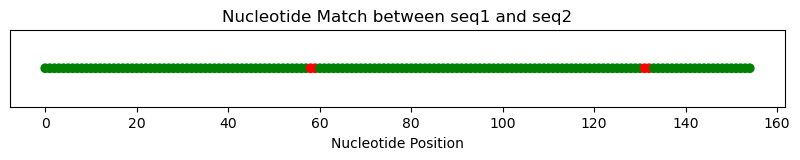

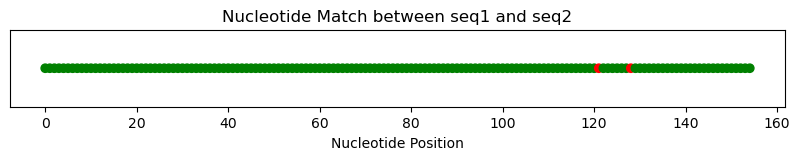

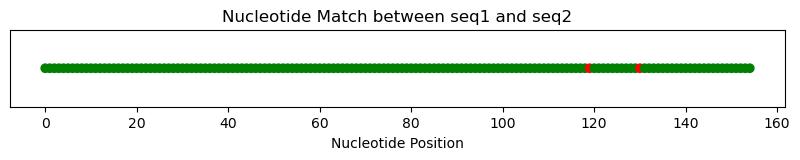

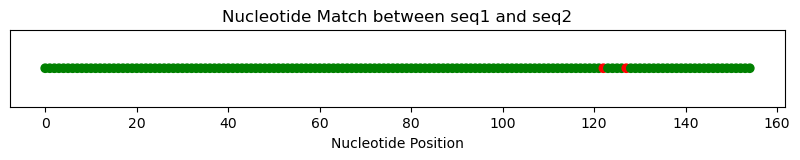

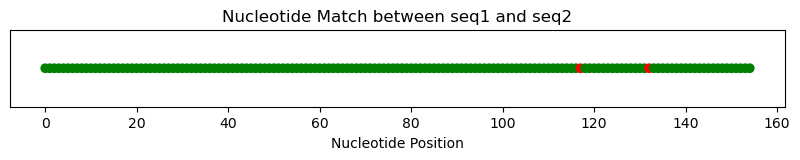

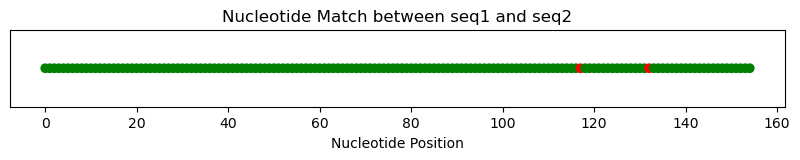

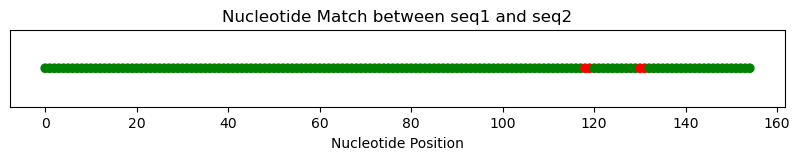

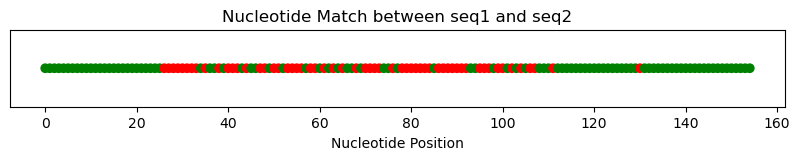

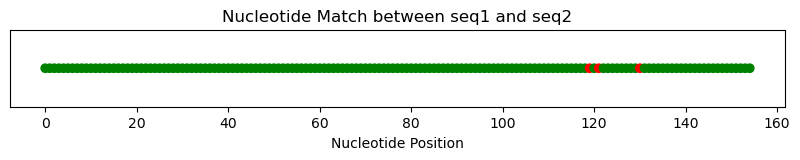

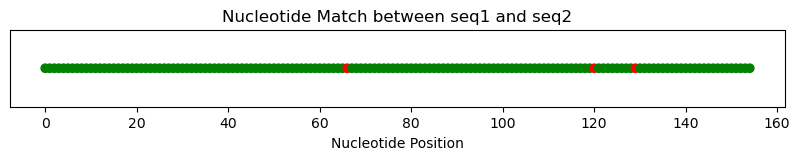

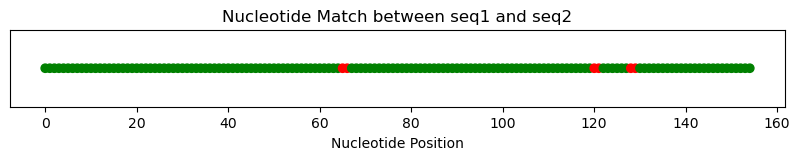

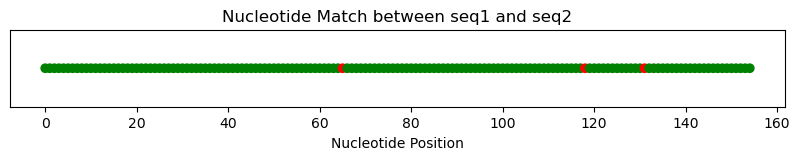

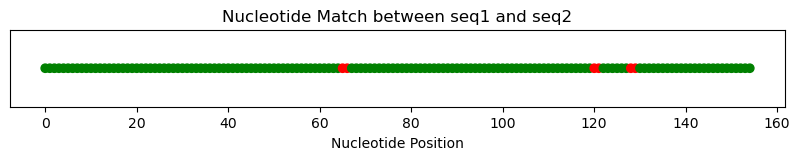

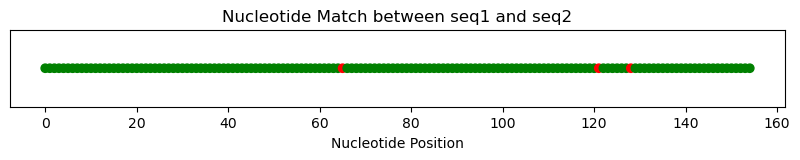

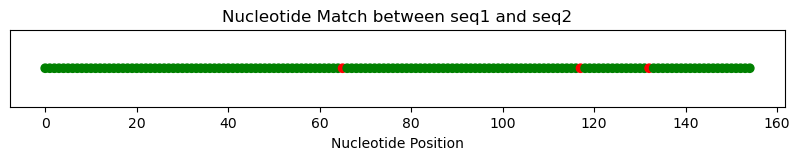

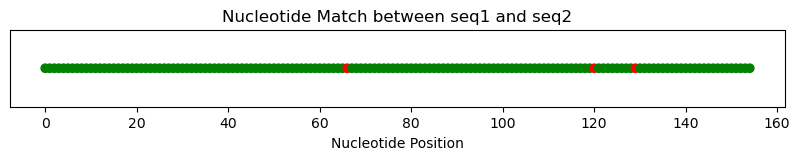

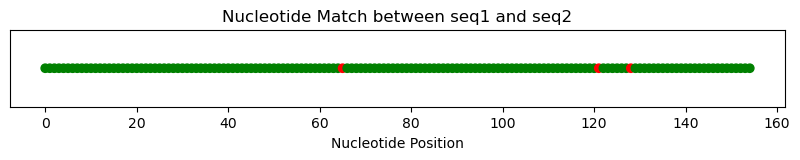

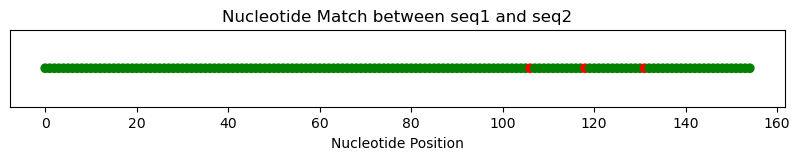

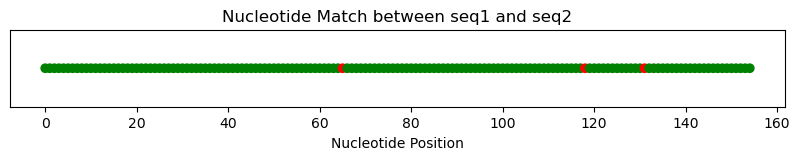

KeyboardInterrupt: 

In [59]:
for i, k in zip(df["seq_id"], df["similar_seq_id"]):
    plot_nucleotide_match(sequences[str(i)], sequences[str(k)])
    plt.pause(0.1)

In [58]:
sequences[str(i)]

'GGGAACGACUCGAGUAGAGUCGAAAAACUGCGAAGGGGGGACGGAGAAGGCUAUGUUGGCCGGGCGACGGUUGUCCCGGUUUAAGCGUGUAGGCUGGUUUUCCAGGCAAAUCAAAAUCUGCUCUUCGGAGCAGAAAAAGAAACAACAACAACAAC'